# Project 3

In [ ]:
# import libraries
import os
import pandas as pd
import numpy as np
from glob import iglob, glob
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import roc_auc_score
import shutil
import math

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Load Data

In [ ]:
# unzip downloaded data
!unzip "/content/drive/MyDrive/data690-dl/Projects/Practical Deep Learning Projects/Project 3/data/AID_Satellite_Scene_Classification.zip" -d "/content"

unzip:  cannot find or open /content/drive/MyDrive/data690-dl/Projects/Practical Deep Learning Projects/Project 3/data/AID_Satellite_Scene_Classification.zip, /content/drive/MyDrive/data690-dl/Projects/Practical Deep Learning Projects/Project 3/data/AID_Satellite_Scene_Classification.zip.zip or /content/drive/MyDrive/data690-dl/Projects/Practical Deep Learning Projects/Project 3/data/AID_Satellite_Scene_Classification.zip.ZIP.


# 2. Data Cleaning/Wrangling

In [ ]:
# get files in training folder 
data_dir = 'AID/'
classes = os.listdir(data_dir)
data_df = pd.DataFrame()
for class_ in classes:
    path = os.path.join(data_dir, class_)
    df = pd.DataFrame({'path': glob(os.path.join(path,'**.jpg'))}) # load the filenames
    data_df = pd.concat([data_df,df])

FileNotFoundError: ignored

In [ ]:
# get image ids
data_df['id'] = data_df.path.map(lambda x: x.split('/')[2].split(".")[0])
# get labels
data_df['label'] = data_df.path.map(lambda x: x.split('/')[1].split(".")[0])
data_df

In [ ]:
data_df

# 3. EDA/View the data

In [ ]:
len(data_df.path)

10000

In [ ]:
#number of classes
data_df.label.nunique()

30

In [ ]:
classes

['SparseResidential',
 'Commercial',
 'Parking',
 'Forest',
 'Airport',
 'Park',
 'Beach',
 'Industrial',
 'Meadow',
 'River',
 'StorageTanks',
 'Bridge',
 'BaseballField',
 'School',
 'Stadium',
 'Mountain',
 'Center',
 'DenseResidential',
 'RailwayStation',
 'BareLand',
 'Church',
 'Square',
 'Farmland',
 'Port',
 'MediumResidential',
 'Pond',
 'Playground',
 'Viaduct',
 'Resort',
 'Desert']

In [ ]:
#all unique classes
data_df.label.unique()

array(['SparseResidential', 'Commercial', 'Parking', 'Forest', 'Airport',
       'Park', 'Beach', 'Industrial', 'Meadow', 'River', 'StorageTanks',
       'Bridge', 'BaseballField', 'School', 'Stadium', 'Mountain',
       'Center', 'DenseResidential', 'RailwayStation', 'BareLand',
       'Church', 'Square', 'Farmland', 'Port', 'MediumResidential',
       'Pond', 'Playground', 'Viaduct', 'Resort', 'Desert'], dtype=object)

In [ ]:
data_df.describe()

,path,id,label
count,10000,10000,10000
unique,10000,10000,30
top,AID/SparseResidential/sparseresidential_35.jpg,sparseresidential_35,Viaduct
freq,1,1,420


In [ ]:
import seaborn as sn
import matplotlib as plt

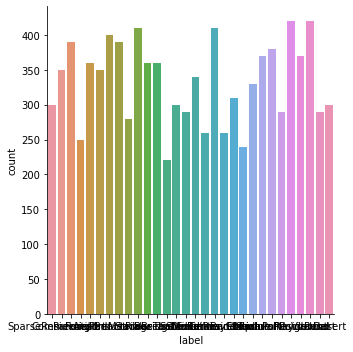

In [ ]:
sn.catplot(x='label', kind='count',data=data_df,)

In [ ]:
#distribution of images count per class
data_df['label'].value_counts()

Viaduct              420
Pond                 420
River                410
DenseResidential     410
Beach                400
Industrial           390
Parking              390
Port                 380
Playground           370
Farmland             370
Airport              360
StorageTanks         360
Bridge               360
Park                 350
Commercial           350
Mountain             340
Square               330
BareLand             310
SparseResidential    300
School               300
Desert               300
Stadium              290
MediumResidential    290
Resort               290
Meadow               280
RailwayStation       260
Center               260
Forest               250
Church               240
BaseballField        220
Name: label, dtype: int64

# 4. Prepare Data for Modeling 
Custom Dataset class and pyTorch Data Loader

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, label_df, data_dir, out_dir, batch_size=32, transform=None, test_transform=None):
        self.img_labels = label_df
        self.data_dir = data_dir
        self.out_dir = out_dir
        self.batch_size = batch_size
        self.transform = transform
        self.test_transform = test_transform
        # to be defined 
        self.train_1 = pd.DataFrame()
        self.train_0 = pd.DataFrame()
        self.test_1 = pd.DataFrame()
        self.test_0 = pd.DataFrame()

    def __len__(self):
        return len(self.img_labels)

    def __prep_data__(self):
        #Setting the shape size of the training and testing by rounding them up
        train_size = math.ceil(self.img_labels.shape[0]*.7)
        test_size = math.floor(self.img_labels.shape[0]*.3)


        #set them as the train and test variable
        self.img_labels = self.img_labels.sample(frac=1).reset_index(drop=True)
        train = self.img_labels[:train_size]
        test = self.img_labels[train_size:]


        #Prints the count of number of files for each label
        print('train data labels:')
        print(train.label.value_counts())

        print('\ntest data labels:')
        print(test.label.value_counts())

        #set a new path
        new_path = 'data' 

        #check if the new path already exist and maing sure to remove it or make a new directory
        if os.path.exists(new_path):
            shutil.rmtree(new_path)
        os.makedirs(new_path)

        # make train/test directories 
        os.mkdir(os.path.join(new_path, 'training_data'))
        os.mkdir(os.path.join(new_path, 'testing_data'))
        train_path = os.path.join(new_path, 'training_data')
        test_path = os.path.join(new_path, 'testing_data')

        

In [ ]:
AID_CNN = CustomImageDataset(label_df=data_df, 
                                   data_dir='/content/AID/', 
                                   out_dir='data', 
                                   batch_size=64,
                              )

In [ ]:
AID_CNN.__len__()

In [ ]:
#Display the prepped data
AID_CNN.__prep_data__()

# 5. Define Model architecture 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

# 6. Train CNN Model

# 7. Hyperparameter Tuning

# 8. Evaluate Model

# 9. Analyze Results
- What class does the model perform best on? Show some sample images.
- What class does it struggle to predict?
